In [40]:
# Import libraries

import pandas as pd
import numpy as np
import math
import json
import re
from datetime import datetime
import seaborn as sns
#import progressbar
from matplotlib import pyplot as plt

from scipy import stats
from sklearn.svm import SVC as svc 
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_score, recall_score
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, make_scorer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

%matplotlib inline

In [42]:
# load datasets
#combined_data = pd.read_csv('combined_data.csv')

url='https://drive.google.com/file/d/1WI-RTwzqE7K6coEOej7FdF6XQ-i6wvQh/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]

combined_data = pd.read_csv(url)

portfolio_cleaned = pd.read_csv('portfolio_cleaned.csv')



# Combined Dataset exploration

In [43]:
# Show combined data
combined_data.head()

,offer_id,customer_id,time_in_days,total_amount,offer_successful,reward,difficulty,duration,channel_email,channel_mobile,...,"age_(10, 20]","age_(20, 30]","age_(30, 40]","age_(40, 50]","age_(50, 60]","age_(60, 70]","age_(70, 80]","age_(80, 90]","age_(90, 100]","age_(100, 110]"
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0610b486422d4921ae7d2bf64640c50b,17.0,23.22,0,5,5,7,1,1,...,0,0,0,0,1,0,0,0,0,0
1,3f207df678b143eea3cee63160fa8bed,0610b486422d4921ae7d2bf64640c50b,21.0,23.22,0,0,0,4,1,1,...,0,0,0,0,1,0,0,0,0,0
2,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0.0,37.67,1,5,5,7,1,1,...,0,0,0,0,0,0,1,0,0,0
3,5a8bc65990b245e5a138643cd4eb9837,78afa995795e4d85b5d9ceeca43f5fef,7.0,49.39,0,0,0,3,1,1,...,0,0,0,0,0,0,1,0,0,0
4,ae264e3637204a6fb9bb56bc8210ddfd,78afa995795e4d85b5d9ceeca43f5fef,17.0,48.28,1,10,10,7,1,1,...,0,0,0,0,0,0,1,0,0,0


In [44]:
combined_data.shape

(66501, 34)

In [45]:
# Show all columns names
combined_data.columns

Index(['offer_id', 'customer_id', 'time_in_days', 'total_amount',
       'offer_successful', 'reward', 'difficulty', 'duration', 'channel_email',
       'channel_mobile', 'channel_social', 'channel_web', 'bogo', 'discount',
       'informational', 'age', 'income', 'year', 'month', 'day', 'gender_F',
       'gender_M', 'gender_O', 'age_(0, 10]', 'age_(10, 20]', 'age_(20, 30]',
       'age_(30, 40]', 'age_(40, 50]', 'age_(50, 60]', 'age_(60, 70]',
       'age_(70, 80]', 'age_(80, 90]', 'age_(90, 100]', 'age_(100, 110]'],
      dtype='object')

In [46]:
portfolio_cleaned.head()

,reward,difficulty,duration,offer_id,channel_email,channel_mobile,channel_social,channel_web,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0


In [7]:
portfolio_cleaned.columns

Index(['reward', 'difficulty', 'duration', 'offer_id', 'channel_email',
       'channel_mobile', 'channel_social', 'channel_web', 'bogo', 'discount',
       'informational'],
      dtype='object')

# Model building
In this section i have built 3 different classifiers and evaluated their performance:

#### Logistic Regression
#### Gradient Boosting
#### Random Forest

After that, in order to visualize the performance of the multi-class classification problem, i will use AUC (Area Under The Curve) ROC (Receiver Operating Characteristics) curve explained, in more detail later.

In [8]:
def calculate_test_and_train(features, target, test_size, scaler = False):
    '''
    INPUT 
        features - features dataset
        target - target / class feature dataset
        test_size - split test size percentage
        scaler - if True applies MinMaxScaler function. False by default
        
    OUTPUT
        Returns train and test splits
    '''
    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(features.values, target.values, test_size=test_size, random_state=42)
    
    if (scaler):
        scaler = MinMaxScaler()
        #transform data
        X_train = scaler.fit_transform(X_train)

    # convert train and test labels to array
    y_train = y_train.ravel()
    y_test = y_test.ravel()
    
    return X_train, X_test, y_train, y_test

In [9]:
def build_model(algorithm, grid_params, scorer, X_train, y_train):
    '''
    Apply RandomizedSearchCV and build the model algorithm with the passed parameters.
    
    INPUT 
        algorithm - algorithm used to create a model
        grid_params - set of grid params
        scorer - scorer
        X_train - train matrix of features
        y_train - train array of the class feature
        
    OUTPUT
        Return the fitted model
    '''
    lr_random = RandomizedSearchCV(
        estimator = algorithm, 
        
        param_distributions = grid_params, 
        scoring=scorer, 
        n_iter = 12, 
        cv = 3, 
        verbose=2, 
        random_state=42, 
        n_jobs = 3)

    # fit train data to the model
    lr_random.fit(X_train, y_train)
    
    return lr_random

In [10]:
# Support function get class classifier name
def get_class_name(clf):
    
    class_name = re.sub("[<>']", '', str(clf.__class__))
    class_name = class_name.split(' ')[1]
    class_name = class_name.split('.')[-1]
    
    return class_name

In [11]:
# Calculate and show model metrics on demand
def show_model_metrics(clf, X_test, y_test, full_outcome = True):
    '''
    Show the main metrics of the model
    
    INPUT 
        clf - classifier model 
        X_test - test features matrix
        y_test - test target feature array
        full_outcome - if True returns the full metrics outcome
    OUTPUT
        Return model metrics
    '''
    class_name = get_class_name(clf)

    y_pred_rf = clf.predict(X_test)

    clf_accuracy = accuracy_score(y_test, y_pred_rf)
    clf_f1_score = f1_score(y_test, y_pred_rf)
    
    precision = precision_score(y_test, y_pred_rf)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, y_pred_rf)
    
    if( full_outcome == True):
        print("%s model accuracy: %.3f" % (class_name, clf_accuracy))
        print("%s model f1-score: %.3f" % (class_name, clf_f1_score))
        print("%s model precision: %.3f" % (class_name, precision))
        print("%s model recall: %.3f" % (class_name, recall))

        # sns.heatmap(evaluate_confussion_matrix(clf, X_train, y_train), annot=True)
        sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap='Blues', square=True)
        plt.show()
    
    
    #false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)
    
    return clf_accuracy, clf_f1_score, y_pred_rf

In [12]:
# Calculate AUC-ROC curve and show a visualization
def show_roc_auc(algorithm_name, y_test, predicted):
    '''
    Display the ROC visualization
    
    INPUT 
        clf - classifier model 
        X_test - test features matrix
        predicted - targets predicted by the clf
        
    OUTPUT
        ROC plot visualization
    '''
    
    # Calculate AUC-ROC measure
    fpr, tpr, thresholds = roc_curve(y_test, predicted)
    roc_auc = auc(fpr, tpr)
    performance_auc[algorithm_name] = roc_auc

    # Show AUC-ROC visualization
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [13]:
# Initialize performance array
performance_auc = {}

# get an scorer
scorer = make_scorer(fbeta_score, beta=0.5)

In [14]:
# Prepare features and target
combined_data.drop(columns=['customer_id', 'offer_id', 'total_amount', 'month', 'day'], inplace=True)

class_label_name = 'offer_successful'

split_val =  0.3

features = combined_data.drop(columns=[class_label_name])
target = combined_data.filter([class_label_name])

# get test and train 
X_train, X_test, y_train, y_test = calculate_test_and_train(features, target, split_val)

In [15]:
features.columns


Index(['time_in_days', 'reward', 'difficulty', 'duration', 'channel_email',
       'channel_mobile', 'channel_social', 'channel_web', 'bogo', 'discount',
       'informational', 'age', 'income', 'year', 'gender_F', 'gender_M',
       'gender_O', 'age_(0, 10]', 'age_(10, 20]', 'age_(20, 30]',
       'age_(30, 40]', 'age_(40, 50]', 'age_(50, 60]', 'age_(60, 70]',
       'age_(70, 80]', 'age_(80, 90]', 'age_(90, 100]', 'age_(100, 110]'],
      dtype='object')

In [16]:
target.columns

Index(['offer_successful'], dtype='object')

# Logistic Regression

In [17]:
# construct a params dict to tune the model
grid_params = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# instantiate a logistic regression classifer object
log_reg = LogisticRegression(random_state=42, solver='liblinear')

# Build the logistic regression model
log_reg_random = build_model(log_reg, grid_params, scorer, X_train, y_train)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [18]:
log_reg_random.best_estimator_

LogisticRegression(C=0.01, penalty='l1', random_state=42, solver='liblinear')

LogisticRegression model accuracy: 0.699
LogisticRegression model f1-score: 0.695
LogisticRegression model precision: 0.667
LogisticRegression model recall: 0.725


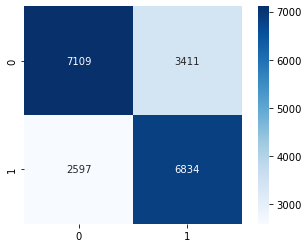

In [19]:
# evaluate logistic regression model's performance
x, y, pred_lr = show_model_metrics(log_reg_random.best_estimator_, X_test, y_test)

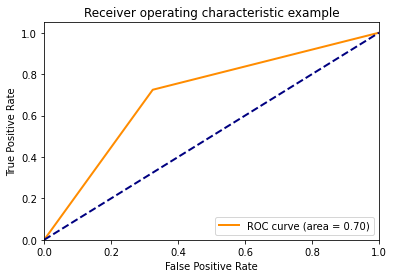

In [20]:
# Call function to display ROC visualization
show_roc_auc('LogisticRegression', y_test, pred_lr)

# Gradient Boosting

In [21]:
# instantiate the classifier object
gb_clf = GradientBoostingClassifier()

# Minimum number of samples required to split a node
min_split_samples = [2, 5, 8, 11]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6, 8]

# Create the random grid
gb_random_grid = {'loss': ['deviance', 'exponential'],
                   'learning_rate': [0.1, 0.01, 0.001],
                   'n_estimators': [10, 30, 50, 100, 150, 200, 250, 300, 350],
                   'min_samples_leaf': min_samples_leaf,
                   'min_samples_split': min_split_samples}

In [22]:
# Call function to build the model
gboost_random = build_model(gb_clf, gb_random_grid, scorer, X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [23]:
# Show the best model estimator
gboost_random.best_estimator_

GradientBoostingClassifier(learning_rate=0.01, loss='exponential',
                           n_estimators=350)

GradientBoostingClassifier model accuracy: 0.727
GradientBoostingClassifier model f1-score: 0.725
GradientBoostingClassifier model precision: 0.691
GradientBoostingClassifier model recall: 0.763


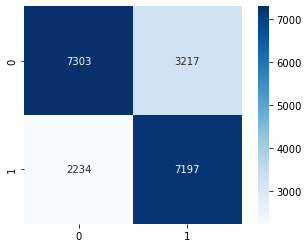

In [24]:
# evaluate random forest classifier model's performance
x, y, pred_gb = show_model_metrics(gboost_random.best_estimator_, X_test, y_test)

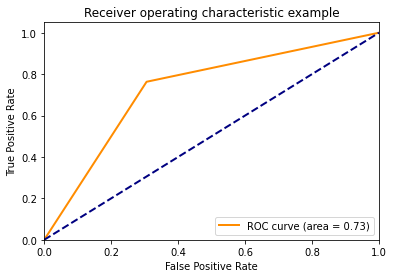

In [25]:
# Call function to display ROC visualization
show_roc_auc('GradientBoosting', y_test, pred_gb)

# Random Forest

In [26]:
# instantiate a random forest classifier
rf_clf = RandomForestClassifier(random_state=42)

# Number of trees in random forest
n_estimators = [10, 50, 100, 150, 200, 250, 300, 350, 500, 1000]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(3, 13)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_split_samples = [2, 5, 8]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid_params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_split_samples,
               'min_samples_leaf': min_samples_leaf}

In [27]:
# Call function to build the model
rf_random = build_model(rf_clf, random_grid_params, scorer, X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [28]:
rf_random.best_params_

{'n_estimators': 500,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 12}

In [29]:
# Show the best model estimator
rf_random.best_estimator_

RandomForestClassifier(max_depth=12, min_samples_split=5, n_estimators=500,
                       random_state=42)

RandomForestClassifier model accuracy: 0.735
RandomForestClassifier model f1-score: 0.729
RandomForestClassifier model precision: 0.706
RandomForestClassifier model recall: 0.753


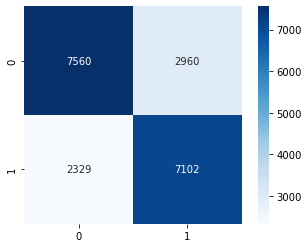

In [30]:
# evaluate random forest classifier model's performance
x, y, pred_rf = show_model_metrics(rf_random.best_estimator_, X_test, y_test)

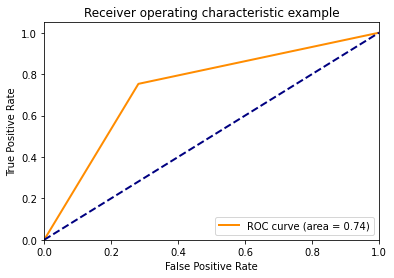

In [31]:
# Call function to display ROC visualization
show_roc_auc('RandomForest', y_test, pred_rf)

# Compare models and performance evaluation
The motivation in this section is compare all three models and their performance in terms of accuraccy, f1score and AUC-ROC curve comparison.


In [32]:
# Evaluate model performances
model_performance = []

classifier_type = ['logistic_regression',
                   'gradient_boosting',
                   'random_forest']


model_performance.append(show_model_metrics(log_reg_random.best_estimator_,
                                                    X_test,
                                                    y_test, full_outcome = False)[:2])

model_performance.append(show_model_metrics(gboost_random.best_estimator_,
                                                    X_test,
                                                    y_test, full_outcome = False)[:2])

model_performance.append(show_model_metrics(rf_random.best_estimator_,
                                                    X_test,
                                                    y_test, full_outcome = False)[:2])

#model_performance.append(show_model_metrics(svm_random.best_estimator_,
                                                    #X_test,
                                                    #y_test, full_outcome = False)[:2])

model_performance = pd.DataFrame(model_performance,
                                 columns=['accuracy', 'f1score'])

classifier_type = pd.DataFrame(classifier_type,
                               columns=['model'])


model_performance = pd.concat([classifier_type, model_performance],
                              axis=1)

model_performance = model_performance.sort_values('accuracy', ascending=False)
model_performance = model_performance.reset_index(drop=True)

# Show model performance table
model_performance

,model,accuracy,f1score
0,random_forest,0.734901,0.728672
1,gradient_boosting,0.726781,0.725321
2,logistic_regression,0.698862,0.694653


<AxesSubplot:title={'center':'Classifier AUC'}, xlabel='AUC', ylabel='Model'>

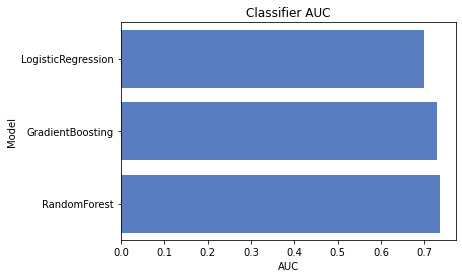

In [33]:
# Show classifier AUC performance comparison
perf = pd.DataFrame.from_dict(performance_auc, orient='index')
perf['Model'] = perf.index
perf['AUC'] = perf[0]
plt.xlabel('AUC')
plt.title('Classifier AUC')
sns.set_color_codes("muted")
sns.barplot(x='AUC', y='Model', data=perf, color="b")

# Conclusions

After build and evaluate the three different models, Random Forest has the best performance and metrics for our data with the best accuracy (0.734), f1score(0.729), precission (0.703) and recall (0.757) . Second Gradient Boosting and finnaly Logistic Regression.

Theses performances could be improved by tunning parameters in future phases. It is important when we building models avoid overfitting, too. Also maybe an interesting practice in this notebook testing with other classification algorithms like SVM or K-NN for instance and add them to the general comparison.

ROC-AUC curve have been used to compare the different classification models: *

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

True Positive Rate
False Positive Rate
#### True Positive Rate (TPR) is a synonym for recall and is therefore defined as follows:

#### TPR = TP / TP+FN

#### False Positive Rate (FPR) is defined as follows:

#### FPR = FP / FP+TN

An ROC curve plots TPR vs. FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives.